In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
    
import sys 
sys.path.insert(0, '../src/')

import warnings; warnings.simplefilter('ignore')
import emcee
import corner
from multiprocess import Pool
import time
import galhalo
import mcmc_aux

import jsm_prephalo, jsm_stats
from scipy.stats import ks_2samp


In [3]:
# file = "../../data/3000_12_8/acc_surv_mass.npy"

# massmat = jsm_prephalo.MassMat(file, phimin=-4) #grab the data
# massmat.prep_data(includenan=False)

# massmat.SAGA_break(Nsamp=100)  #make the SAGA sets

# np.save("../../data/MCMC/SAGA_samples.npy", massmat.lgMh_mat)

creating the truth sample

In [4]:
lgMh_mat = np.load("../../data/MCMC/SAGA_samples.npy")

alpha, delta, sigma = 3, 2, 0.3

lgMs_mat = galhalo.SHMR(lgMh_mat, alpha, delta, sigma)

In [5]:
stat = jsm_stats.SatStats(lgMs_mat)

stat.satfreq(6.5)

stat.maxsatmass()


Picking one SAGA set to be the data and excluding it

In [6]:
#np.save("../../data/MCMC/mock_lgMh.npy", lgMh_mat[mock_index])

mock_index = 5 # need to exclude this set

mock_lgMh = lgMh_mat[mock_index]

maxsatmass_CDF_mat = np.delete(stat.maxsatmass_CDF_mat, mock_index, axis=0)

satfreq_PDF_mat = np.delete(stat.maxsatmass_PDF_mat, mock_index, axis=0)

now to define the truth values

In [7]:
data_CDF = np.average(maxsatmass_CDF_mat, axis=0)

data_PDF = np.average(satfreq_PDF_mat, axis=0)

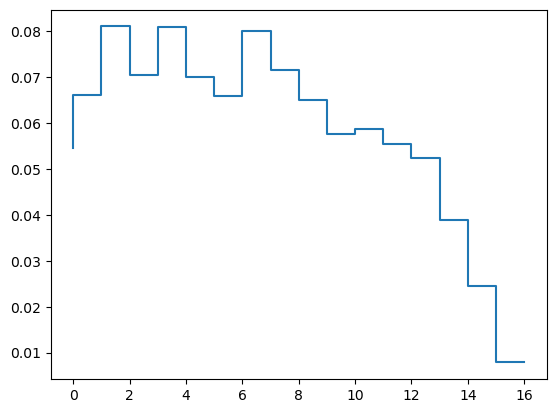

In [8]:
plt.step(stat.satfreq_bins[:-1], data_PDF)

writing the out the model

In [9]:
def forward(theta):

    alpha, delta, sigma = theta #inputting the parameters
    lgMs = galhalo.SHMR(mock_lgMh, alpha, delta, sigma)

    satfreq = jsm_stats.satfreq(lgMs, 6.5)
    maxsatmass = jsm_stats.maxsatmass(lgMs)

    return satfreq, maxsatmass

now working on the likelyhoods

In [29]:
def get_satfreq_lnL(model, data):
    lnL = np.sum(np.ma.log((model*100)*data))
    if type(lnL) == np.ma.core.MaskedConstant:
        return -np.inf
    else:
        return lnL

def get_maxsatmass_lnL(model, data):
    return np.log(1 - ks_2samp(data, model)[1])

def lnlike(theta):
    satfreq, maxsatmass = forward(theta)
    lnL_satfreq = get_satfreq_lnL(satfreq, data_PDF)
    lnL_maxsatmass = get_maxsatmass_lnL(maxsatmass, data_CDF)
    return lnL_satfreq

In [15]:
-np.inf + 6

-inf

In [30]:
def lnprior(theta):
    alpha, delta, sigma = theta
    if 0.5 < alpha < 3.5 and -0.5 < delta < 3.5 and 0 < sigma < 4:
        return 0.0
    else:
        return -np.inf

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + lnlike(theta)

In [31]:
def MCMC_RUN(theta_0, lnprob, nwalkers=1000, niter=5000, ndim=3, ncores=8, converge=False):

    p0 = [np.array(theta_0) + 1e-2 * np.random.randn(ndim) for i in range(nwalkers)]
    
    with Pool(ncores) as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool)
        start = time.time()
        sampler.run_mcmc(p0, niter)
        end = time.time()
        multi_time = end - start
        print("Run took {0:.1f} seconds".format(multi_time))

    if converge==True:
        tau = sampler.get_autocorr_time()
        print('$\\alpha$ took', tau[0], 'steps')
        print('$\\delta$ took', tau[1], 'steps')
        print('$\\sigma$ took', tau[2], 'steps')

    return sampler

In [32]:
start_theta = [2, .3, 0.5]

mcmc_out = MCMC_RUN(start_theta, lnprob)

run = mcmc_aux.inspect_run(mcmc_out, fid_theta=[alpha, delta, sigma])


Run took 325.6 seconds


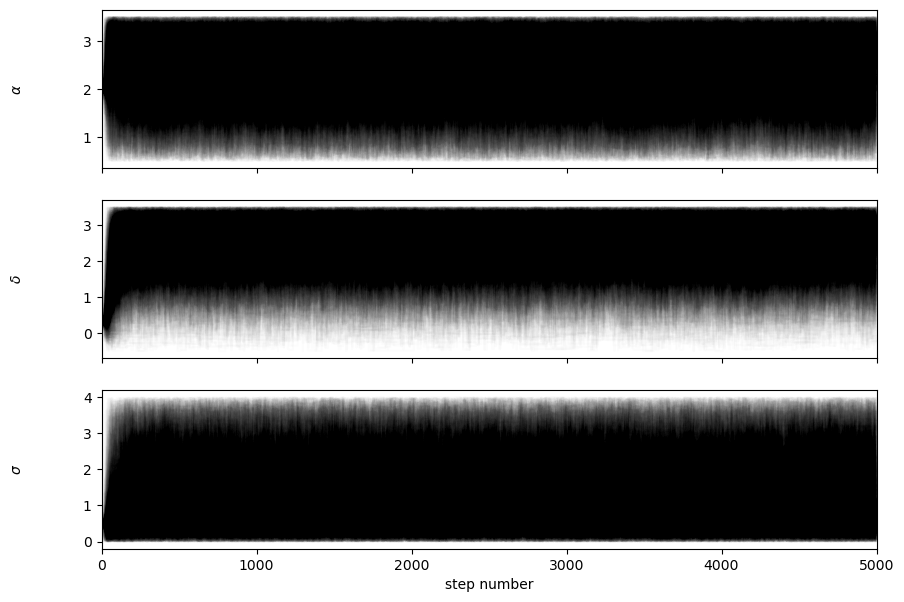

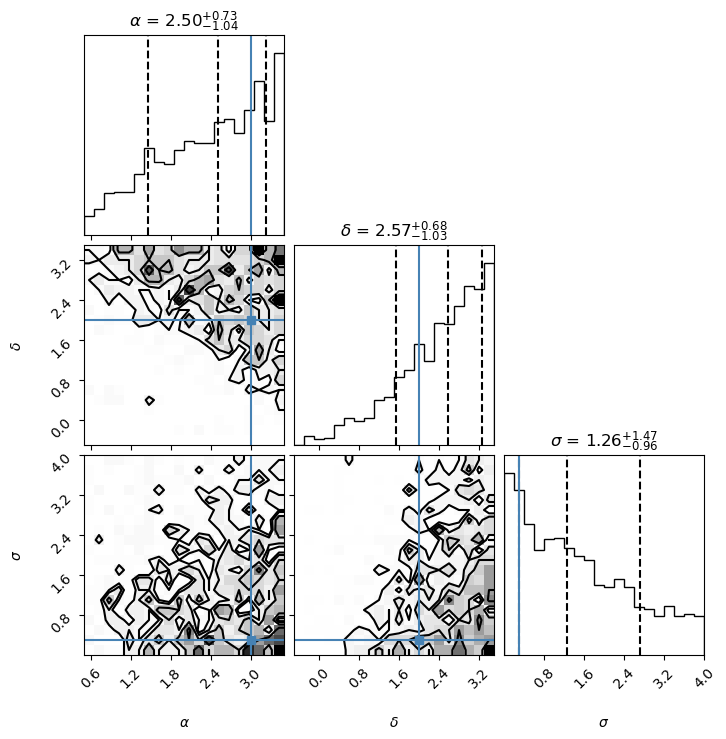

not normalizing for the upscatter


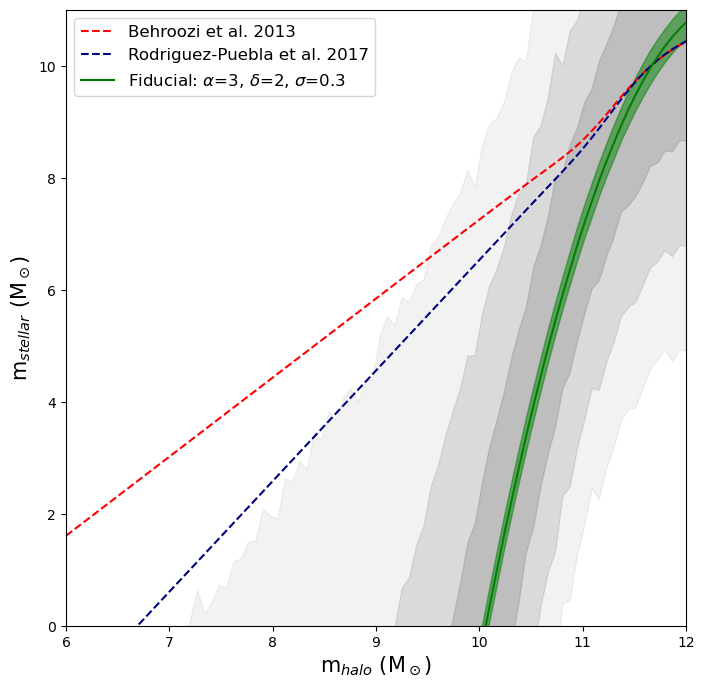

In [33]:
run.chain_plot()
run.corner_plot()
run.SHMR_plot()
#run.chi_square_plot()
#val_i = run.best_fit_values()
#vals.append(val_i)